In [3]:
!mkdir -p data models

In [1]:
%%capture
!python -m pip install --upgrade pip
!pip install pytorch_lightning
!pip install --upgrade torch torchvision torchaudio
!pip install matplotlib

In [2]:
%%writefile vae.py
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialVAE(nn.Module):
    def __init__(self, in_channels=1, latent_channels=4):
        super().__init__()
        # Encoder: input (B,1,28,28)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),  # (B,32,14,14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),           # (B,64,7,7)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),          # (B,128,4,4)
            nn.ReLU(),
        )
        self.mu_conv = nn.Conv2d(128, latent_channels, kernel_size=1)
        self.logvar_conv = nn.Conv2d(128, latent_channels, kernel_size=1)
        
        # Decoder: from latent (B, latent_channels, 4, 4) to reconstructed image (B,1,28,28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 128, kernel_size=3, stride=2, padding=1),  # (B,128,7,7) [output_padding may be 0]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B,64,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),   # (B,32,28,28)
            nn.ReLU(),
            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        self.latent_shape = (latent_channels, 4, 4)
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_conv(h)
        logvar = self.logvar_conv(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

Writing vae.py


In [3]:
%%writefile unet.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import math


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, timesteps):
        device = timesteps.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = timesteps[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(32, in_channels)
        self.norm2 = nn.GroupNorm(32, out_channels)
        self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x, t):
        h = self.norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        t_emb = self.time_mlp(t)[:, :, None, None]
        h = h + t_emb
        h = self.norm2(h)
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(32, channels)
        self.q = nn.Conv2d(channels, channels, kernel_size=1)
        self.k = nn.Conv2d(channels, channels, kernel_size=1)
        self.v = nn.Conv2d(channels, channels, kernel_size=1)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)

    def forward(self, x):
        b, c, h, w = x.shape
        x_norm = self.norm(x)
        q = self.q(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        k = self.k(x_norm).reshape(b, c, -1)
        v = self.v(x_norm).reshape(b, c, -1).permute(0, 2, 1)
        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)
        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(b, c, h, w)
        return x + self.proj_out(out)

class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(channels, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)
        self.downsample = Downsample(out_channels)

    def forward(self, x, t):
        skip_connections = []
        for block in self.res_blocks:
            x = block(x, t)
            skip_connections.append(x)
        if self.use_attn:
            x = self.attn(x)
        x_down = self.downsample(x)
        return x_down, skip_connections

def center_crop(x, target_shape):
    _, _, h, w = x.shape
    th, tw = target_shape
    start_h = (h - th) // 2
    start_w = (w - tw) // 2
    return x[:, :, start_h:start_h+th, start_w:start_w+tw]

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim, num_res_blocks, use_attn=False):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=4, stride=2, padding=1)
        self.res_blocks = nn.ModuleList([
            ResBlock(in_channels + out_channels if i == 0 else out_channels, out_channels, time_emb_dim)
            for i in range(num_res_blocks)
        ])
        self.use_attn = use_attn
        if use_attn:
            self.attn = AttentionBlock(out_channels)

    def forward(self, x, skip_connections, t):
        x = self.upsample(x)
        skip = skip_connections.pop()  # one skip connection per block
        if x.shape[2:] != skip.shape[2:]:
            x = center_crop(x, skip.shape[2:])
        x = torch.cat([x, skip], dim=1)
        for block in self.res_blocks:
            x = block(x, t)
        if self.use_attn:
            x = self.attn(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=64,
                 channel_mults=(1, 2, 4), num_res_blocks=2, time_emb_dim=256,
                 attn_resolutions=None):
        super().__init__()
        if attn_resolutions is None:
            attn_resolutions = []

        self.time_embedding = nn.Sequential(
            SinusoidalPosEmb(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim * 4),
            nn.SiLU(),
            nn.Linear(time_emb_dim * 4, time_emb_dim)
        )

        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        self.down_blocks = nn.ModuleList()
        in_ch = base_channels
        for i, mult in enumerate(channel_mults):
            out_ch = base_channels * mult
            use_attn = (i in attn_resolutions)
            self.down_blocks.append(DownBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.mid_block1 = ResBlock(in_ch, in_ch, time_emb_dim)
        self.mid_attn = AttentionBlock(in_ch)
        self.mid_block2 = ResBlock(in_ch, in_ch, time_emb_dim)

        self.up_blocks = nn.ModuleList()
        for i, mult in enumerate(reversed(channel_mults)):
            out_ch = base_channels * mult
            use_attn = ((len(channel_mults) - 1 - i) in attn_resolutions)
            self.up_blocks.append(UpBlock(in_ch, out_ch, time_emb_dim, num_res_blocks, use_attn))
            in_ch = out_ch

        self.final_norm = nn.GroupNorm(32, in_ch)
        self.final_act = nn.SiLU()
        self.final_conv = nn.Conv2d(in_ch, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        t = t.to(x.device)
        t_emb = self.time_embedding(t)
        x = self.initial_conv(x)
        skip_connections_all = []
        for block in self.down_blocks:
            x, skip_connections = block(x, t_emb)
            skip_connections_all.append(skip_connections)
        x = self.mid_block1(x, t_emb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t_emb)
        for block in self.up_blocks:
            skip_connections = skip_connections_all.pop()
            x = block(x, skip_connections, t_emb)
        x = self.final_norm(x)
        x = self.final_act(x)
        return self.final_conv(x)


Writing unet.py


100%|██████████| 9.91M/9.91M [00:09<00:00, 1.01MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 170kB/s]
100%|██████████| 1.65M/1.65M [00:04<00:00, 381kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.13MB/s]


=== Pixel-Based Rectified Flow Stage 1: Training Flow-1 ===
Rectified Flow-1 (Pixel) Epoch [1/20] Loss: 0.1315
Rectified Flow-1 (Pixel) Epoch [2/20] Loss: 0.1020
Rectified Flow-1 (Pixel) Epoch [3/20] Loss: 0.0969
Rectified Flow-1 (Pixel) Epoch [4/20] Loss: 0.0945
Rectified Flow-1 (Pixel) Epoch [5/20] Loss: 0.0929
Rectified Flow-1 (Pixel) Epoch [6/20] Loss: 0.0917
Rectified Flow-1 (Pixel) Epoch [7/20] Loss: 0.0906
Rectified Flow-1 (Pixel) Epoch [8/20] Loss: 0.0900
Rectified Flow-1 (Pixel) Epoch [9/20] Loss: 0.0893
Rectified Flow-1 (Pixel) Epoch [10/20] Loss: 0.0889
Rectified Flow-1 (Pixel) Epoch [11/20] Loss: 0.0885
Rectified Flow-1 (Pixel) Epoch [12/20] Loss: 0.0882
Rectified Flow-1 (Pixel) Epoch [13/20] Loss: 0.0877
Rectified Flow-1 (Pixel) Epoch [14/20] Loss: 0.0869
Rectified Flow-1 (Pixel) Epoch [15/20] Loss: 0.0871
Rectified Flow-1 (Pixel) Epoch [16/20] Loss: 0.0869
Rectified Flow-1 (Pixel) Epoch [17/20] Loss: 0.0866
Rectified Flow-1 (Pixel) Epoch [18/20] Loss: 0.0861
Rectified Flo

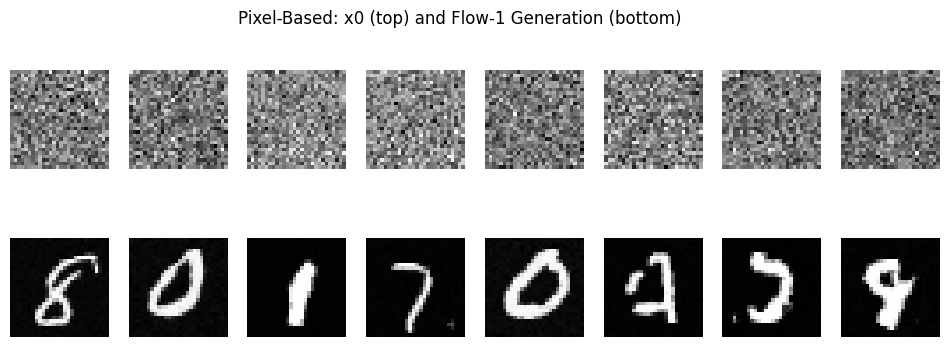

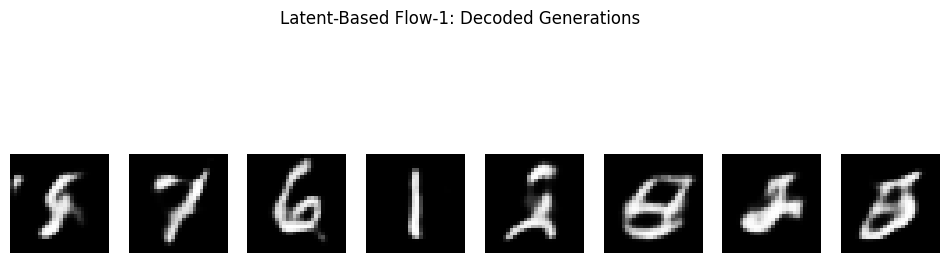

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

from unet import UNet
from vae import SpatialVAE


def euler_integration(x0, model, num_steps=100):
    dt = 1.0 / num_steps
    x = x0.clone()
    batch_size = x0.size(0)
    for i in range(num_steps):
        t = torch.full((batch_size,), i * dt, device=x0.device)
        x = x + model(x, t) * dt
    return x

def train_rectified_flow1(model, dataloader, device, num_epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)  
            batch_size = images.size(0)
            x0 = torch.randn_like(images, device=device)
            t = torch.rand(batch_size, device=device)
            t_expanded = t.view(batch_size, 1, 1, 1)
            x_t = (1 - t_expanded) * x0 + t_expanded * images
            target_velocity = images - x0 
            pred_velocity = model(x_t, t)
            loss = criterion(pred_velocity, target_velocity)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        print(f"Rectified Flow-1 (Pixel) Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model

def train_rectified_flow2(model, dataloader, device, num_epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for x0, x_target in dataloader:
            x0 = x0.to(device)
            x_target = x_target.to(device)
            batch_size = x0.size(0)
            t = torch.rand(batch_size, device=device)
            t_expanded = t.view(batch_size, 1, 1, 1)
            x_t = (1 - t_expanded) * x0 + t_expanded * x_target
            target_velocity = x_target - x0
            pred_velocity = model(x_t, t)
            loss = criterion(pred_velocity, target_velocity)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        print(f"Rectified Flow-2 (Pixel) Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model


def train_rectified_flow1_latent(model, dataloader, vae, device, num_epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    vae.eval()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, _ in dataloader:
            images = images.to(device)
            batch_size = images.size(0)
            with torch.no_grad():
                mu, logvar = vae.encode(images)
                z = vae.reparameterize(mu, logvar)
                z = z.view(images.size(0), *vae.latent_shape)
            z0 = torch.randn_like(z, device=device)
            t = torch.rand(batch_size, device=device)
            t_expanded = t.view(batch_size, 1, 1, 1)
            z_t = (1 - t_expanded) * z0 + t_expanded * z
            target_velocity = z - z0
            pred_velocity = model(z_t, t)
            loss = criterion(pred_velocity, target_velocity)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        print(f"Rectified Flow-1 (Latent) Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model

def train_rectified_flow2_latent(model, dataloader, device, num_epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for z0, z_target in dataloader:
            z0 = z0.to(device)
            z_target = z_target.to(device)
            batch_size = z0.size(0)
            t = torch.rand(batch_size, device=device)
            t_expanded = t.view(batch_size, 1, 1, 1)
            z_t = (1 - t_expanded) * z0 + t_expanded * z_target
            target_velocity = z_target - z0
            pred_velocity = model(z_t, t)
            loss = criterion(pred_velocity, target_velocity)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(dataloader)
        print(f"Rectified Flow-2 (Latent) Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")
    return model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64

transform = transforms.Compose([transforms.ToTensor()])
mnist_full = datasets.MNIST(root='data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='data', train=False, download=True, transform=transform)
train_size = int(0.8 * len(mnist_full))
val_size = len(mnist_full) - train_size
mnist_train, mnist_val = torch.utils.data.random_split(mnist_full, [train_size, val_size])
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False, num_workers=4)

print("=== Pixel-Based Rectified Flow Stage 1: Training Flow-1 ===")
model1_pixel = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)
model1_pixel = train_rectified_flow1(model1_pixel, train_loader, device, num_epochs=20, lr=1e-3)
torch.save(model1_pixel.state_dict(), "rectified_flow1_pixel.pth")

print("=== Pixel-Based: Generating Fixed Pairs using Flow-1 ===")
fixed_pairs_pixel = []
num_fixed = 10000
model1_pixel.eval()
with torch.no_grad():
    for _ in range(num_fixed // batch_size):
        x0 = torch.randn(batch_size, 1, 28, 28, device=device)
        x_generated = euler_integration(x0, model1_pixel, num_steps=100)
        fixed_pairs_pixel.append((x0.cpu(), x_generated.cpu()))
x0_all = torch.cat([pair[0] for pair in fixed_pairs_pixel], dim=0)
x_target_all = torch.cat([pair[1] for pair in fixed_pairs_pixel], dim=0)
fixed_dataset_pixel = TensorDataset(x0_all, x_target_all)
fixed_loader_pixel = DataLoader(fixed_dataset_pixel, batch_size=batch_size, shuffle=True)
torch.save(fixed_dataset_pixel, "fixed_pairs_pixel_dataset.pt")
print("Fixed pairs dataset (pixel) saved as 'fixed_pairs_pixel_dataset.pt'")

print("=== Pixel-Based Rectified Flow Stage 2: Training Flow-2 ===")
model2_pixel = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=32,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)
model2_pixel = train_rectified_flow2(model2_pixel, fixed_loader_pixel, device, num_epochs=20, lr=1e-3)
torch.save(model2_pixel.state_dict(), "rectified_flow2_pixel.pth")

print("=== Training Spatial VAE for Latent Diffusion ===")
vae = SpatialVAE(in_channels=1, latent_channels=4).to(device)

vae_optimizer = optim.Adam(vae.parameters(), lr=1e-3)
vae.train()
num_vae_epochs = 5
for epoch in range(num_vae_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        x_recon, mu, logvar = vae(images)
        recon_loss = nn.functional.binary_cross_entropy(x_recon, images, reduction='sum') / images.size(0)
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / images.size(0)
        loss = recon_loss + kl_loss
        vae_optimizer.zero_grad()
        loss.backward()
        vae_optimizer.step()
        running_loss += loss.item()
    print(f"VAE Epoch [{epoch+1}/{num_vae_epochs}] Loss: {running_loss/len(train_loader):.4f}")
torch.save(vae.state_dict(), "spatial_vae.pth")

vae.eval()

print("=== Latent-Based Rectified Flow Stage 1: Training Flow-1 (Latent) ===")

model1_latent = UNet(
    in_channels=vae.latent_shape[0],
    out_channels=vae.latent_shape[0],
    base_channels=64,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)
model1_latent = train_rectified_flow1_latent(model1_latent, train_loader, vae, device, num_epochs=20, lr=1e-3)
torch.save(model1_latent.state_dict(), "rectified_flow1_latent.pth")

print("=== Latent-Based: Generating Fixed Latent Pairs using Flow-1 ===")
fixed_pairs_latent = []
for _ in range(num_fixed // batch_size):
    z0 = torch.randn(batch_size, *vae.latent_shape, device=device)
    with torch.no_grad():
        z_generated = euler_integration(z0, model1_latent, num_steps=100)
    fixed_pairs_latent.append((z0.cpu(), z_generated.cpu()))
z0_all = torch.cat([pair[0] for pair in fixed_pairs_latent], dim=0)
z_target_all = torch.cat([pair[1] for pair in fixed_pairs_latent], dim=0)
fixed_dataset_latent = TensorDataset(z0_all, z_target_all)
fixed_loader_latent = DataLoader(fixed_dataset_latent, batch_size=batch_size, shuffle=True)
torch.save(fixed_dataset_latent, "fixed_pairs_latent_dataset.pt")
print("Fixed latent pairs dataset saved as 'fixed_pairs_latent_dataset.pt'")

print("=== Latent-Based Rectified Flow Stage 2: Training Flow-2 (Latent) ===")
model2_latent = UNet(
    in_channels=vae.latent_shape[0],
    out_channels=vae.latent_shape[0],
    base_channels=32,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)
model2_latent = train_rectified_flow2_latent(model2_latent, fixed_loader_latent, device, num_epochs=20, lr=1e-3)
torch.save(model2_latent.state_dict(), "rectified_flow2_latent.pth")

model1_pixel.eval()
with torch.no_grad():
    x0_vis = torch.randn(batch_size, 1, 28, 28, device=device)
    x_generated_vis = euler_integration(x0_vis, model1_pixel, num_steps=100)
x0_vis = x0_vis.cpu()
x_generated_vis = x_generated_vis.cpu()
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(2, 8, i+1)
    plt.imshow(x0_vis[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.subplot(2, 8, i+9)
    plt.imshow(x_generated_vis[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Pixel-Based: x0 (top) and Flow-1 Generation (bottom)")
plt.show()

model1_latent.eval()
with torch.no_grad():
    z0_vis = torch.randn(batch_size, *vae.latent_shape, device=device)
    z_generated_vis = euler_integration(z0_vis, model1_latent, num_steps=100)
    x_generated_latent = vae.decode(z_generated_vis)
x_generated_latent = x_generated_latent.cpu()
plt.figure(figsize=(12, 4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(x_generated_latent[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle("Latent-Based Flow-1: Decoded Generations")
plt.show()